<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/irsa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IRSA** (Infrared, Near-Infrared)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_2000.png)

In [ ]:
!pip install astropy astroquery requests reproject -q
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astropy import coordinates
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
from astropy import coordinates as coords
from reproject import reproject_interp
import matplotlib.pyplot as plt

In [ ]:
# Some tasks like multi-wavelength astronomy require high memory to load data
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Runtime: {:.1f} gigabytes of available RAM (>20 GB ideal)\n'.format(ram_gb))

Runtime: 54.8 gigabytes of available RAM (>20 GB ideal)



#### **Define astronomical object and get skycoordinates**

In [ ]:
# Define object
object_name = 'M51'

*e.g. M31 (Andromeda galaxy), M104 (Sombrero galaxy), M51 (Whirlpool galaxy), M42 (Orion nebula), NGC 3372 (Carina nebula)*

In [ ]:
# Get and set skycoordinates of object
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord

skyobject = Simbad.query_object(object_name)
ra_hms = skyobject['RA'][0]
dec_dms = skyobject['DEC'][0]
coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit=('hourangle', 'deg'), frame='icrs')
print(skyobject)
print("\nCoordinates:")
print("RA (h:m:s):", ra_hms)
print("DEC (d:m:s):", dec_dms)

MAIN_ID      RA          DEC      RA_PREC ... COO_WAVELENGTH     COO_BIBCODE     SCRIPT_NUMBER_ID
          "h:m:s"      "d:m:s"            ...                                                    
------- ------------ ------------ ------- ... -------------- ------------------- ----------------
  M  51 13 29 52.698 +47 11 42.93       7 ...              I 2006AJ....131.1163S                1

Coordinates:
RA (h:m:s): 13 29 52.698
DEC (d:m:s): +47 11 42.93


In [ ]:
# Convert from Right Ascension (RA) and Declination (DEC) to decimal degree
coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit=('hourangle', 'deg'), frame='icrs')
ra_deg = coord.ra.deg # round(coord.ra.deg, 2)
dec_deg = coord.dec.deg # round(coord.dec.deg, 2)

print("RA in degrees:", ra_deg)
print("DEC in degrees:", dec_deg)

RA in degrees: 202.46957499999996
DEC in degrees: 47.19525833333333


In [ ]:
# Convert from decimal degree to Right Ascension (RA) and Declination (DEC)
coord = SkyCoord(ra=ra_deg, dec=dec_deg, unit='deg', frame='icrs')

# RA: hours, minutes, seconds. DEC: degrees, arcminutes, arcseconds
ra_hms = coord.ra.to_string(unit='hour', sep=' ', precision=3, pad=True)
dec_dms = coord.dec.to_string(unit='deg', sep=' ', precision=2, alwayssign=True, pad=True)

print("RA (h:m:s):", ra_hms)
print("DEC (d:m:s):", dec_dms)

RA (h:m:s): 13 29 52.698
DEC (d:m:s): +47 11 42.93


In [ ]:
# Reverse check to see to which object the coordinates belong
coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit=('hourangle', 'deg'), frame='icrs')
result = Simbad.query_region(coord, radius='0d0m5s')  # Search within a small radius (5 arcseconds)
if result:
    print(result['MAIN_ID'][0])  # Show main name of the object
else:
    print("No object found in SIMBAD at these coordinates.")
object_name = 'MAIN_ID'

M  51


frame='icrs' refers to [International Celestial Ref. System](https://aa.usno.navy.mil/faq/ICRS_doc)
*  Origin is barycenter of Solar System. This means ICRS origin is not fixed to Earth but moves with Solar System's center of mass.
* Axes are defined by the positions of extragalactic sources, primarily quasars observed using Very Long Baseline Interferometry (VLBI). The primary plane is as close as possible to the mean equator at J2000.0 (January 1, 2000, 12:00 TT).  The origin of right ascension is close to the dynamical equinox of J2000.0.
* Accuracy: The ICRF3 defines the ICRS axes with an accuracy of about 20 microarcseconds.
* Realization: The International Celestial Reference Frame (ICRF) is a catalog of precise positions of extragalactic sources that provides a practical realization of the ICRS. The latest version, ICRF3, includes the positions of over 4000 extragalactic sources, mostly quasars. The ICRF is maintained by the International Earth Rotation and Reference Systems Service (IERS).
* Relationship to other systems: ICRS is closely aligned with the J2000 equatorial coordinate system, but it's more accurate and stable. Transformations exist to convert coordinates between ICRS and other celestial reference systems

In [ ]:
# Set coordinates manually and verify correct object
coord = SkyCoord('189.9976d -11.623054d', frame='icrs')
result = Simbad.query_region(coord, radius='0d0m5s')  # Search within a small radius (5 arcseconds)
if result:
    print(result['MAIN_ID'][0])  # Show main name of the object
else:
    print("No object found in SIMBAD at these coordinates.")
object_name = 'MAIN_ID'

M 104


#### **FITS File**

In [ ]:
# Option 1: Load via IRSA (for predefined object)
from astroquery.ipac.irsa import Irsa
spitzer_images = Irsa.query_sia(pos=(coord, 1 * u.arcmin), collection='spitzer_seip').to_table()

# Open a cutout image for one of the science images
irsa_image = spitzer_images[spitzer_images['dataproduct_subtype'] == 'science'][5]
with fits.open(irsa_image['access_url'], use_fsspec=True) as hdul:
    cutout = Cutout2D(hdul[0].section, position=coord, size=2 * u.arcmin, wcs=WCS(hdul[0].header))

# Open FITS file
hdul = fits.open(irsa_image['access_url'], use_fsspec=True)

# Print file information
hdul.info()

Filename: <class 'fsspec.implementations.http.HTTPFile'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      77   (2480, 3095)   float32   


In [ ]:
# Option 2: Load file directly
!wget https://raw.githubusercontent.com/deltorobarba/astrophysics/master/file-u-001737-5-0039.fits
fits_file = './file-u-001737-5-0039.fits'

# Open the FITS file
hdul = fits.open(fits_file)

# Print file information
hdul.info()

--2024-12-21 19:43:55--  https://raw.githubusercontent.com/deltorobarba/astrophysics/master/file-u-001737-5-0039.fits
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12447360 (12M) [application/octet-stream]
Saving to: ‘file-u-001737-5-0039.fits.4’

file-u-001737-5-003 100%[===================>]  11.87M  --.-KB/s    in 0.03s   

2024-12-21 19:43:55 (348 MB/s) - ‘file-u-001737-5-0039.fits.4’ saved [12447360/12447360]

Filename: ./file-u-001737-5-0039.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (2048, 1489)   float32   
  1                1 ImageHDU         6   (2048,)   float32   
  2                1 BinTableHDU     27   1R x 3C   [49152E, 2048E, 1489E]   
  3                1 BinTableHDU     7

In [ ]:
# Access more details from primary HDU (Header/Data Unit) to get data
primary_hdu = hdul[0]
data = primary_hdu.data
print(primary_hdu.header) # Display the header to learn more about the file
print(repr(hdul[0].header))  # Science data HDU header

SIMPLE  =                    T /                                                BITPIX  =                  -32 / 32 bit floating point                          NAXIS   =                    2                                                  NAXIS1  =                 2048                                                  NAXIS2  =                 1489                                                  EXTEND  =                    T /Extensions may be present                       BZERO   =              0.00000 /Set by MRD_SCALE                                BSCALE  =              1.00000 /Set by MRD_SCALE                                TAI     =        4476739701.74 / 1st row - Number of seconds since Nov 17 1858  RA      =            313.13132 / 1st row - Right ascension of telescope boresighDEC     =           -6.213656  / 1st row - Declination of telescope boresight (dSPA     =              97.851  / 1st row - Camera col position angle wrt north (IPA     =             111.891  / 1st row

In [ ]:
# Close the FITS file
hdul.close()

#### **IRSA (Infrared, Near-Infrared) - Collections via SIA**

**IRSA Catalog** refers to the astronomical data and resources provided by the **Infrared Science Archive (IRSA)**. IRSA is an essential facility hosted by NASA, tasked with curating and distributing infrared astronomical data collected from missions and projects. It enables astronomers to search for and access large-scale datasets related to infrared observations of celestial objects.

1. **Infrared Data**: IRSA focuses on data in the infrared spectrum, which allows astronomers to study phenomena such as:
   - Star formation.
   - Interstellar dust and gas.
   - Galaxy formation and evolution.
   - Objects obscured in visible light by dust.

2. **Access to Multiple Missions**: IRSA provides access to data from several missions, such as:
   - **Spitzer Space Telescope** (e.g., GLIMPSE, SEIP catalogs).
   - **WISE (Wide-field Infrared Survey Explorer)** and its catalogs.
   - **2MASS (Two Micron All-Sky Survey)** catalog.
   - **SOFIA (Stratospheric Observatory for Infrared Astronomy)** data.
   - **Planck** and more.

3. **Data Search and Retrieval Tools**:
   - **Gator**: A catalog search engine to query and filter data based on astronomical criteria.
   - **IRSA Viewer**: A tool for visualizing infrared images and overlaying catalogs.
   - **VO (Virtual Observatory) Tools**: Interoperable tools for accessing and analyzing data.

4. **Application**:
   - Study of celestial objects (stars, galaxies, planetary systems).
   - Analysis of large-scale cosmic structures.
   - Identification of exoplanets, brown dwarfs, and asteroids.
   - Examining regions of the universe hidden in optical wavelengths.
   - Infrared observations are crucial for understanding star formation in dense molecular clouds.
   - It helps in identifying distant galaxies obscured by interstellar dust.

https://astroquery.readthedocs.io/en/latest/ipac/irsa/irsa.html

https://astroquery.readthedocs.io/projects/keflavich-astroquery/en/latest/irsa.html

In [ ]:
# Query IRSA collections (contains images)
Irsa.list_collections()

collection
object
akari_allskymaps
blast
bolocam_gps
bolocam_lh
bolocam_planck_sz
champ
cosmos
euclid_ero
goals


**Infrared Surveys (images and catalogs)**
* `spitzer_seip`: Enhanced Imaging Products
* `spitzer_sha`: Spitzer Heritage Archive
* `spitzer_c2d`: c2d Legacy Survey Images
* `spitzer_glimpse`: GLIMPSE Survey Images
* `wise_allwise`: AllWISE Atlas Images
* `wise_allsky`: WISE All-Sky Release Atlas Images
* `wise_neowiser`: NEOWISE-R Atlas Images
* `2mass`: 2MASS All-Sky Atlas Images

**Near-Infrared Surveys**
* `2mass`: 2MASS Atlas Images
* `ukidss_las`: UKIDSS Large Area Survey Images
* `ukidss_gcs`: UKIDSS Galactic Clusters Survey Images

**Dust/Galactic Structure**
* `issa`: IRAS Sky Survey Atlas Images

**Recent/Ongoing Surveys**
* `wise_neowiser`: NEOWISE-R Atlas Images
* `unwise_atlas`: unWISE Atlas Images
* `cosmos_tiles`: COSMOS Survey Tiles

**Specific Scientific Studies**
* `ptf_images`: PTF Survey Images
* `akari_images`: AKARI Survey Images

In [ ]:
# Select collection (images)
collection = 'spitzer_seip'

In [ ]:
# Query IMAGES with IRSA-SIA from IRSA for object images (in 'coord') from a given telescope (in 'collection')
obj_details = Irsa.query_sia(collection=collection, pos=(coord, 1 * u.arcmin))
obj_details

<DALResultsTable length=148>
   s_ra      s_dec        facility_name      ... o_ucd  upload_row_id
   deg        deg                            ...                     
 float64    float64           object         ... object     int64    
---------- --------- ----------------------- ... ------ -------------
10.6551277 41.413963 Spitzer Space Telescope ...                    1
10.6551277 41.413963 Spitzer Space Telescope ...                    1
10.6551277 41.413963 Spitzer Space Telescope ...                    1
10.6551277 41.413963 Spitzer Space Telescope ...                    1
10.6551277 41.413963 Spitzer Space Telescope ...                    1
10.6551277 41.413963 Spitzer Space Telescope ...                    1
10.6551277 41.413963 Spitzer Space Telescope ...                    1
10.6551277 41.413963 Spitzer Space Telescope ...                    1
10.6551277 41.413963 Spitzer Space Telescope ...                    1
       ...       ...                     ... ...    ...      

In [ ]:
# Turn details into a table
images = Irsa.query_sia(pos=(coord, 1 * u.arcmin), collection=collection).to_table()
images[:3] # show only first 3 results

s_ra,s_dec,facility_name,instrument_name,dataproduct_subtype,calib_level,dataproduct_type,energy_bandpassname,energy_emband,obs_id,s_resolution,em_min,em_max,em_res_power,proposal_title,access_url,access_format,access_estsize,t_exptime,s_region,obs_collection,obs_intent,algorithm_name,facility_keywords,instrument_keywords,environment_photometric,proposal_id,proposal_pi,proposal_project,target_name,target_type,target_standard,target_moving,target_keywords,obs_release_date,s_xel1,s_xel2,s_pixel_scale,position_timedependent,t_min,t_max,t_resolution,t_xel,obs_publisher_did,s_fov,em_xel,pol_states,pol_xel,cloud_access,o_ucd,upload_row_id
deg,deg,,,,,,,,,arcsec,m,m,,,,,kbyte,s,deg,,,,,,,,,,,,,,,,,,arcsec,,d,d,s,,,deg,,,,,,
float64,float64,object,object,object,int16,object,object,object,object,float64,float64,float64,float64,object,object,object,int64,float64,object,object,object,object,object,object,bool,object,object,object,object,object,bool,bool,object,object,int64,int64,float64,bool,float64,float64,float64,int64,object,float64,int64,object,int64,object,object,int64
83.798853,-5.7209295000000004,Spitzer Space Telescope,IRAC,noise,3,image,IRAC1,Infrared,40044081.40044081-82.IRAC,1.66,3.17e-06,3.92e-06,4.8,Spitzer Enhanced Imaging Products,https://irsa.ipac.caltech.edu/data/SPITZER/Enhanced/SEIP/images/4/0044/40044081/2/40044081-82/40044081.40044081-82.IRAC.1.std.fits,image/fits,75845,--,POLYGON ICRS 84.1564503 -6.0908973 84.1559876 -5.3505739 83.441551 -5.3505739 83.4410883 -6.0908973 84.1564503 -6.0908973,spitzer_seip,science,mosaic,,,--,,,Spitzer,,field,False,False,,2013-12-19 00:00:00,4268,4442,0.600012,False,--,--,--,--,ivo://irsa.ipac/spitzer_seip/40044081.40044081-82.IRAC,0.7257029991253574,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-spitzer"", ""key"":""spitzer/seip/seip_science/images/4/0044/40044081/2/40044081-82/40044081.40044081-82.IRAC.1.std.fits"", ""region"": ""us-west-2""}}",,1
83.798853,-5.7209295000000004,Spitzer Space Telescope,IRAC,science,3,image,IRAC1,Infrared,40044081.40044081-82.IRAC,1.66,3.17e-06,3.92e-06,4.8,Spitzer Enhanced Imaging Products,https://irsa.ipac.caltech.edu/data/SPITZER/Enhanced/SEIP/images/4/0044/40044081/2/40044081-82/40044081.40044081-82.IRAC.1.median_mosaic.fits,image/fits,75845,--,POLYGON ICRS 84.1564503 -6.0908973 84.1559876 -5.3505739 83.441551 -5.3505739 83.4410883 -6.0908973 84.1564503 -6.0908973,spitzer_seip,science,mosaic,,,--,,,Spitzer,,field,False,False,,2013-12-19 00:00:00,4268,4442,0.600012,False,--,--,--,--,ivo://irsa.ipac/spitzer_seip/40044081.40044081-82.IRAC,0.7257029991253574,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-spitzer"", ""key"":""spitzer/seip/seip_science/images/4/0044/40044081/2/40044081-82/40044081.40044081-82.IRAC.1.median_mosaic.fits"", ""region"": ""us-west-2""}}",,1
83.798853,-5.7209295000000004,Spitzer Space Telescope,IRAC,noise,3,image,IRAC1,Infrared,40044081.40044081-82.IRAC,1.66,3.17e-06,3.92e-06,4.8,Spitzer Enhanced Imaging Products,https://irsa.ipac.caltech.edu/data/SPITZER/Enhanced/SEIP/images/4/0044/40044081/2/40044081-82/40044081.40044081-82.IRAC.1.median_mosaic_unc.fits,image/fits,75845,--,POLYGON ICRS 84.1564503 -6.0908973 84.1559876 -5.3505739 83.441551 -5.3505739 83.4410883 -6.0908973 84.1564503 -6.0908973,spitzer_seip,science,mosaic,,,--,,,Spitzer,,field,False,False,,2013-12-19 00:00:00,4268,4442,0.600012,False,--,--,--,--,ivo://irsa.ipac/spitzer_seip/40044081.40044081-82.IRAC,0.7257029991253574,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-spitzer"", ""key"":""spitzer/seip/seip_science/images/4/0044/40044081/2/40044081-82/40044081.40044081-82.IRAC.1.median_mosaic_unc.fits"", ""region"": ""us-west-2""}}",,1


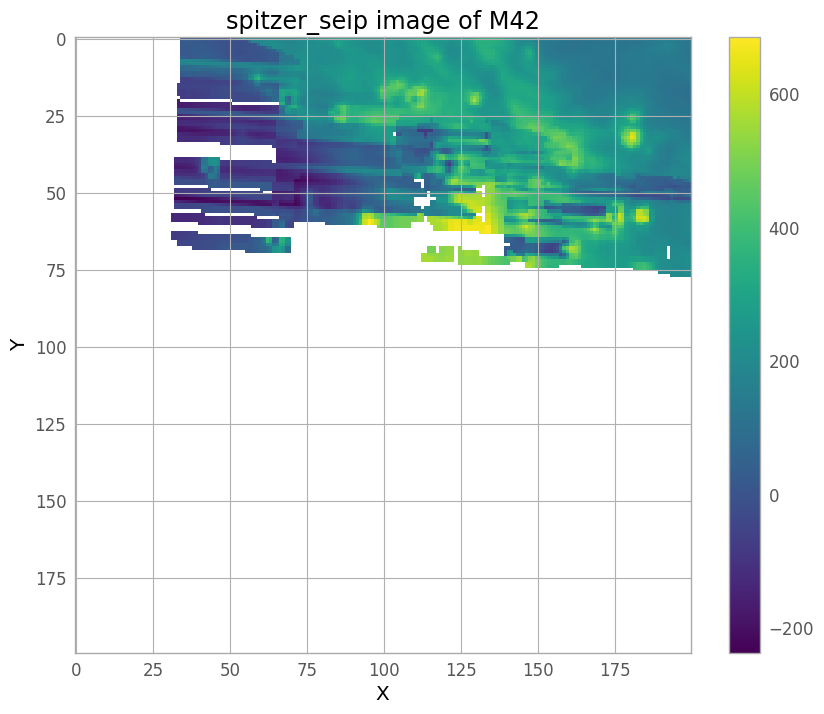

(<matplotlib.image.AxesImage at 0x78b3fd9fcc10>,
 None)

In [ ]:
# Open cutout image for one science image
irsa_images = Irsa.query_sia(pos=(coord, 1 * u.arcmin), collection=collection).to_table()
irsa_image = irsa_images[irsa_images['dataproduct_subtype'] == 'science'][0]
with fits.open(irsa_image['access_url'], use_fsspec=True) as hdul:
    cutout = Cutout2D(hdul[0].section, position=coord, size=2 * u.arcmin, wcs=WCS(hdul[0].header))

plt.figure(figsize=(10, 8)).add_subplot().set(title=f'{collection} image of {object_name}', xlabel='X', ylabel='Y')
plt.imshow(cutout.data, cmap='viridis'), plt.colorbar(), plt.show()

In [ ]:
# Simple image access queries from IRSA for galaxy images from Spitzer telescope

#coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit=('hourangle', 'deg'), frame='icrs')
spitzer_images = Irsa.query_sia(pos=(coord, 1 * u.arcmin), collection=collection).to_table()

# Open a cutout image for one of the science images
science_image = spitzer_images[spitzer_images['dataproduct_subtype'] == 'science'][5]
with fits.open(science_image['access_url'], use_fsspec=True) as hdul:
    cutout = Cutout2D(hdul[0].section, position=coord, size=2 * u.arcmin, wcs=WCS(hdul[0].header))

plt.figure(figsize=(10, 8)).add_subplot().set(title=f'{collection} image of {object_name}', xlabel='X', ylabel='Y')
plt.imshow(cutout.data, cmap='viridis'), plt.colorbar(), plt.show()

In [ ]:
# How many science picture are there in the catalog for the specific object?
irsa_images_count = len(irsa_images[irsa_images['dataproduct_subtype'] == 'science'])
print("Number of science images:", irsa_images_count)

Number of science images: 36


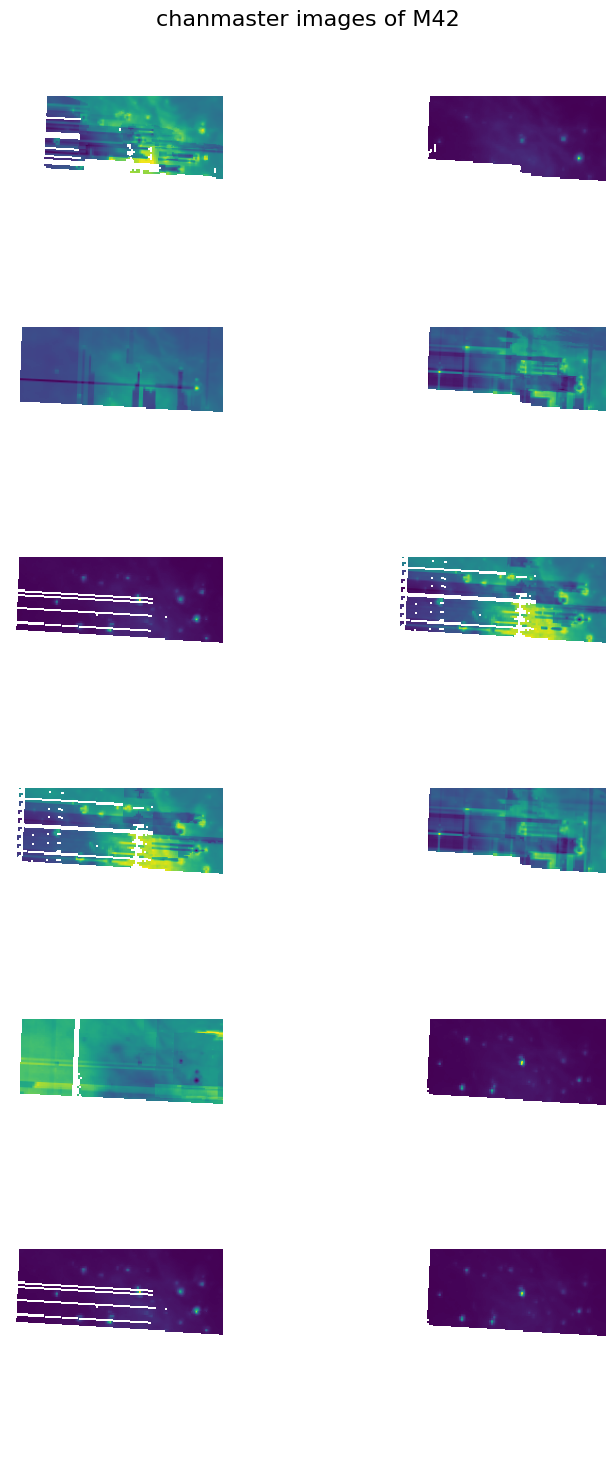

In [ ]:
# Simple image access queries from IRSA for object images from telescope
irsa_images = Irsa.query_sia(pos=(coord, 1 * u.arcmin), collection=collection).to_table()
irsa_images = irsa_images[irsa_images['dataproduct_subtype'] == 'science'] # Filter science images only

# Limit to a max number of images
max_images = 12
irsa_images_count = min(len(irsa_images), max_images)

# Set up the figure for a grid (2 images per row, total number of images/2 rows)
n_rows = (irsa_images_count + 1) // 2  # Using ceiling division to handle odd numbers
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 2.5 * n_rows))

# Loop through each of the science images
for i in range(irsa_images_count):
    # Access each science image URL
    irsa_image = irsa_images[i]
    with fits.open(irsa_image['access_url'], use_fsspec=True) as hdul:
        cutout = Cutout2D(hdul[0].section, position=coord, size=2 * u.arcmin, wcs=WCS(hdul[0].header))
        # Plot the cutout in the grid
        ax = axes[i // 2, i % 2]  # Calculate row and column for 2 images per row
        ax.imshow(cutout.data, cmap='viridis')
        ax.axis('off')  # Hide axes for clarity

# Hide empty subplots if odd number of images
if irsa_images_count % 2:
    axes[-1, -1].axis('off')

plt.suptitle(f'{mission} images of {object_name}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the title
plt.show()

#### **IRSA (Infrared, Near-Infrared) - Catalogs**

In [ ]:
# 'IRSA catalogs' list of available astronomical catalogs in IRSA's database
# These are collections of astronomical measurements and observations organized into specific catalogs (2MASS, WISE, etc.)
from astroquery.ipac.irsa import Irsa
Irsa.list_catalogs()

{'herschel.phpdp_single_plus_unimap': 'Herschel PHPDP Single-extension and Unimap Images',
 'herschel.phpdp_images': 'PACS Highly Processed Data Products (PHPDP)',
 'herschel.ppdisks_spectral': 'PPDISKS Spectra',
 'herschel.shpdp_spectra': 'SPIRE HPDP Spectra',
 'herschel.shpdp_cubes': 'SPIRE HPDP Cubes',
 'herschel.vngs_images': 'VNGS Images',
 'herschel.vngs_spectra': 'VNGS Spectra',
 'herschel.vngs_cubes': 'VNGS Spectral Cubes',
 'herschel.hhli_pacs_photo': 'Herschel HHLI PACS Photo',
 'herschel.hhli_pacs_par': 'Herschel HHLI PACS Parallel',
 'herschel.hhli_spire_photo': 'Herschel HHLI SPIRE Photo',
 'herschel.hhli_spire_par': 'Herschel HHLI SPIRE Parallel',
 'herschel.hhli_images': 'Herschel High Level Images (HHLI)',
 'herschel.prismas': 'PRISMAS Spectra',
 'herschel.hevics_multi': 'Herschel Virgo Cluster Survey (HeVICS) Images',
 'herschel.hevics_single': 'Herschel HeVICS Single-extension Images',
 'herschel.hgbs_images': 'HGBS Images',
 'herschel.sag4_images': 'SAG-4 Images',
 '

In [ ]:
# Queries over a polygon
#table = Irsa.query_region(object_name, catalog="fp_psc", spatial="Polygon",
#polygon=[coord.SkyCoord(ra=10.1, dec=10.1, unit=(u.deg, u.deg), frame='icrs'),
#         coord.SkyCoord(ra=10.0, dec=10.1, unit=(u.deg, u.deg), frame='icrs'),
#         coord.SkyCoord(ra=10.0, dec=10.0, unit=(u.deg, u.deg), frame='icrs')
#        ])
#print(table)

In [ ]:
# Direct TAP query to the IRSA server
query = ("SELECT TOP 10 ra,dec,j_m,j_msigcom,h_m,h_msigcom,k_m,k_msigcom,ph_qual,cc_flg "
         "FROM fp_psc WHERE CONTAINS(POINT('ICRS',ra, dec), CIRCLE('ICRS',10.6846947,41.2689392,5.819))=1")
#          "FROM fp_psc WHERE CONTAINS(POINT('ICRS',ra, dec), CIRCLE('ICRS',202.48417,47.23056,0.4))=1")
results = Irsa.query_tap(query=query).to_qtable()
results

/usr/local/lib/python3.10/dist-packages/pyvo/dal/query.py:339: DALOverflowWarning: Partial result set. Potential causes MAXREC, async storage space, etc.
  warn("Partial result set. Potential causes MAXREC, async storage space, etc.",


ra,dec,j_m,j_msigcom,h_m,h_msigcom,k_m,k_msigcom,ph_qual,cc_flg
deg,deg,mag,mag,mag,mag,mag,mag,,
float64,float64,float32,float32,float32,float32,float32,float32,object,object
17.182749,43.699284,16.484,0.105,15.971,0.145,15.949,0.236,BBD,000
17.198810,43.716602,15.869,0.065,15.295,0.090,15.174,0.123,AAB,000
17.190077,43.718616,14.606,0.031,13.990,0.033,13.763,0.037,AAA,000
17.198377,43.714397,16.412,0.097,15.796,0.138,15.752,0.182,ABC,000
17.174449,43.714855,15.046,0.039,14.365,0.044,14.352,0.063,AAA,000
17.186766,43.715275,15.655,0.059,15.427,0.090,15.548,0.163,AAC,000
17.189046,43.706406,16.128,0.088,15.689,0.111,15.572,0.172,ABC,000
17.205421,43.752987,12.666,0.022,12.145,0.022,12.072,0.021,AAA,000


In [ ]:
# Reverse check if coordinate belong to correct object
coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit=('hourangle', 'deg'), frame='icrs')
result = Simbad.query_region(coord, radius='0d0m5s')  # Search within a small radius (5 arcseconds)
if result:
    print(result['MAIN_ID'][0])  # Show the main name of the object
else:
    print("No object found in SIMBAD at these coordinates.")

M 104


**Infrared Surveys (catalogs)**
* `seip_science`: The source catalog from SEIP
* `spitzer_c2d`: Catalog from the c2d Legacy Survey
* `spitzer_glimpse`: Catalog from the GLIMPSE Survey
* `allwise`: The AllWISE Source Catalog (combines data from WISE All-Sky, 3-Band Cryo, and Post-Cryo surveys)
* `wise_allsky`: The original WISE All-Sky Release Source Catalog
* `neowise`: NEOWISE-R Single Exposure Source Database
* `fp_psc`: 2MASS Point Source Catalog
* `fp_xsc`: 2MASS Extended Source Catalog
* `iras_psc`: IRAS Point Source Catalog
* `iras_fsc`: IRAS Faint Source Catalog

**Near-Infrared Surveys**
* `fp_psc`: 2MASS Point Source Catalog
* `fp_xsc`: 2MASS Extended Source Catalog
* `ukidss`: UKIRT Infrared Deep Sky Survey Catalog

**Dust/Galactic Structure**
* `iras_psc`: IRAS Point Source Catalog
* `iras_fsc`: IRAS Faint Source Catalog
* `irsa_dust`: IRAS/COBE Dust Maps (catalog-like service)

**Recent/Ongoing Surveys**
* `neowise`: NEOWISE-R Single Exposure Source Database
* `unwise`: unWISE Source Catalog
* `cosmos`: COSMOS Source Catalog

**Specific Scientific Studies**
* `ptf`: Palomar Transient Factory Source Catalog
* `mass_goals`: Great Observatories All-sky LIRG Survey Catalog
* `akari`: AKARI/IRC Point Source Catalogue


In [ ]:
# Select catalog
catalog = 'fp_psc' # fp_psc, seip_science, allwise

In [ ]:
# Query IRSA Catalog Data (not images) via Catalog by object name
from astropy import units as u
table = Irsa.query_region(object_name, catalog=catalog, spatial="Cone",radius=2 * u.arcmin)
print(table)

    ra        dec     err_maj err_min err_ang ... scan_key coadd_key coadd        htm20       
   deg        deg      arcsec  arcsec   deg   ...                                             
---------- ---------- ------- ------- ------- ... -------- --------- ----- -------------------
190.005012 -11.644973    0.18    0.16     179 ...    14166    325797    21 4801974309023208448
189.992615 -11.642853    0.12    0.08       0 ...    14166    325797    21 4801974309035221504
189.968588 -11.621228    0.29    0.27      61 ...    14165    325794   256 4801974310545245696
189.964884 -11.624651    0.23    0.22      68 ...    14165    325794   256 4801974310546982912
189.970931 -11.624470    0.21    0.20      16 ...    14165    325794   256 4801974310548540928
189.966373 -11.624717    0.22    0.21      36 ...    14165    325794   256 4801974310550177792
189.992973 -11.629558    0.28    0.26       8 ...    14166    325797    21 4801974311217245696
189.984300 -11.626866    0.34    0.31      88 ... 

In [ ]:
# Query IRSA Catalog Data (not images) via Catalog by coordinates
#ra_deg = 121.1743
#dec_deg = -21.5733
coord = SkyCoord(ra_deg, dec_deg, unit='deg', frame='galactic')
table = Irsa.query_region(coordinates=coord, catalog=catalog, radius='0d2m0s')
print(table)

    ra       dec    err_maj err_min err_ang ... ext_key scan_key coadd_key coadd        htm20       
   deg       deg     arcsec  arcsec   deg   ...                                                     
--------- --------- ------- ------- ------- ... ------- -------- --------- ----- -------------------
81.452044 14.345671    0.18    0.14       4 ...      --    20091    462080   115 4804790086808475136
81.463502 14.347169    0.10    0.06       0 ...      --    20091    462080   115 4804790086821100032
81.441912 14.329261    0.23    0.22      29 ...      --    20091    462080   115 4804790086859249152
81.468876 14.337527    0.28    0.27     167 ...      --    20091    462080   115 4804790086880148992
81.447868 14.338982    0.25    0.20       4 ...      --    20091    462080   115 4804790086920480256
81.454412 14.344996    0.11    0.07       1 ...      --    20091    462080   115 4804790086921932288
81.468002 14.376749    0.10    0.06       0 ...      --    20091    462080   115 4804790087